Sistem Pengenalan Wajah

In [1]:
import cv2
import face_recognition
import os
import math
import numpy as np
from datetime import datetime

videoCapture = cv2.VideoCapture(0)

def markAttendance(regNumber, name):
    f = open("Attendance.csv", "r+")
    data = f.readlines()
    regNumberList = []
    for line in data:
        entry = line.split(',')
        regNumberList.append(entry[0])
    if regNumber not in regNumberList:
        time = datetime.now()
        timeFormat = time.strftime('%H:%M:%S')
        f.writelines(f'\n{regNumber},{name},{timeFormat}')
        print(f"Pengguna {name} dengan nomor registrasi {regNumber} berhasil ditambahkan.")

def getAccuracy(faceDistance, faceMatchThreshold = 0.6):
    if faceDistance > faceMatchThreshold:
        range = (1.0 - faceMatchThreshold)
        linearValue = (1.0 - faceDistance) / (range * 2.0)
        return linearValue
    else:
        range = faceMatchThreshold
        linearValue = 1.0 - (faceDistance / (range * 2.0))
        return linearValue + ((1.0 - linearValue) * math.pow((linearValue - 0.5) * 2, 0.2))

def addNewUser():
    ret, frame = videoCapture.read()
    imageName = input("Masukkan nama file gambar (format: Nama.NomorRegistrasi.jpg): ")
    cv2.imwrite(f"imageData/{imageName}", frame)
    reloadDataset()

def reloadDataset():
    global allPaths, allNames, allRegNumbers, allEncodings
    allPaths = os.listdir("imageData")
    allNames = []
    allRegNumbers = []
    allEncodings = []
    for index in range(len(allPaths)):
        allNames.append(allPaths[index].split(".")[0])
        allRegNumbers.append(allPaths[index].split(".")[1])
        image = face_recognition.load_image_file("imageData/" + allPaths[index])
        temp = face_recognition.face_encodings(image)[0]
        allEncodings.append(temp)
reloadDataset()

while True:
    ret, frame = videoCapture.read()
    frame = cv2.resize(frame, (0, 0), fx=2, fy=1.6)
    resizedFrame = cv2.resize(frame, (0, 0), fx=0.2, fy=0.2)
    requiredFrame = cv2.cvtColor(resizedFrame, cv2.COLOR_BGR2RGB)
    faceLocation = face_recognition.face_locations(requiredFrame)
    faceEncoding = face_recognition.face_encodings(requiredFrame, faceLocation)

    faceNames = []
    for encoding in faceEncoding: 
        ismatched = face_recognition.compare_faces(allEncodings, encoding)
    matchedName = "Unknown"

    faceDistance = face_recognition.face_distance(allEncodings, encoding)
    if len(faceDistance) > 1:
        if faceDistance[0] > faceDistance[1]:
            minimumFaceDistance = faceDistance[1]
        else:
            minimumFaceDistance = faceDistance[0]
    else:
        minimumFaceDistance = faceDistance[0]

    accuracy = getAccuracy(minimumFaceDistance)*100
    bestMatchIndex = np.argmin(faceDistance)

    if ismatched[bestMatchIndex] and accuracy > 80:
        matchedName = allNames[bestMatchIndex]
        markAttendance(allRegNumbers[bestMatchIndex], matchedName)
    faceNames.append(matchedName)

    for (top, right, bottom, left), name in zip(faceLocation, faceNames):
        top *= 5
        right *= 5
        bottom *= 5
        left *= 5
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)
        cv2.putText(frame, name, (left + 6, bottom - 10), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0, 255, 0), 2)
        if(accuracy > 80):
            cv2.putText(frame, "%.2f"%accuracy + "%", (left + 6, bottom + 30), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 0), 2)
    cv2.putText(frame, "Tekan 'A' untuk tambahkan pengguna baru", (20, 50), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 0), 2)
    cv2.putText(frame, "Tekan 'Q' untuk keluar", (20, 90), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 255, 0), 2)
    cv2.imshow("Absensi", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('a'):
        addNewUser()

videoCapture.release()
cv2.destroyAllWindows()

Pengguna Suci dengan nomor registrasi 002 berhasil ditambahkan.


Visualisasi Distribusi Data

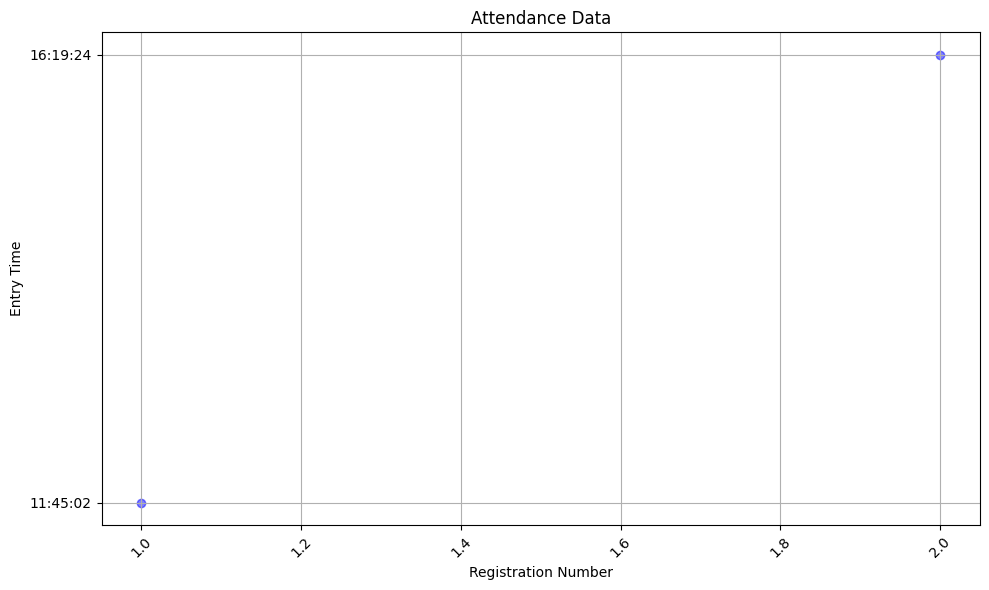

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

attendance_data = pd.read_csv("Attendance.csv")
reg_numbers = attendance_data['Registration_No.']
names = attendance_data['Name']
entry_times = attendance_data['Entry_Time']

plt.figure(figsize=(10, 6))
plt.scatter(reg_numbers, entry_times, marker='o', color='blue', alpha=0.5)
plt.title('Attendance Data')
plt.xlabel('Registration Number')
plt.ylabel('Entry Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

>- Visualisasi data dapat menggunakan scatterplot, dimana ketika terdapat beberapa data presensi maka dapat dilihat mayoritas jam kedatangan dari para pengguna. Selain itu, dapat juga dilihat persebaran datanya serta melihat distribusi datanya apakah normal atau tidak.
>- Dalam contoh ini, hanya menggunakan 2 data sehingga persebaran datanya hanya sederhana.
>- Data dengan nomor registrasi 001 (`Dikta.001.jpg`) merupakan pengguna baru dimana datanya berdasarkan perekaman kamera yang kemudian tersimpan dalam folder `imageData`. Setelah itu ketika dilakukan deteksi wajah lagi, maka data kehadirannya dapat dicatat dalam `Attendance.csv`.
>- Sedangkan untuk data dengan registrasi 002 (`Suci.002.jpg`) merupakan pengguna dengan data wajah yang sudah tersimpan dalam folder `imageData`.

Visualisasi Variasi Fitur Wajah

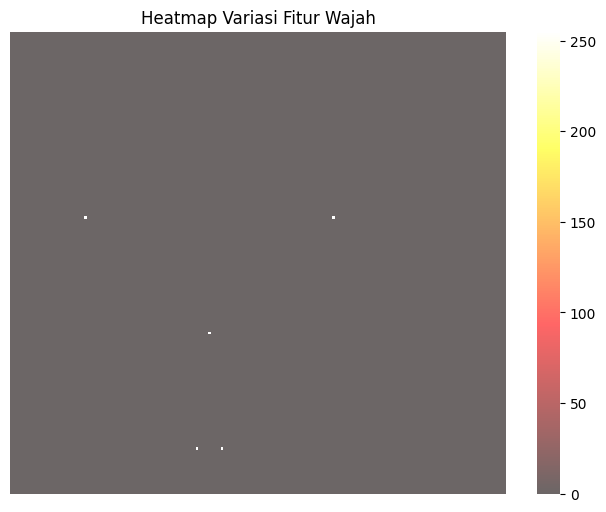

In [3]:
import seaborn as sns

image_path = "imageData/Suci.002.jpg"
image = cv2.imread(image_path)

#Simulasi deteksi wajah dengan mengambil area tengah gambar
#Contoh area wajah yang dipotong
face_roi = image[100:300, 100:300]

#Heatmap dari area wajah
heatmap = np.zeros_like(face_roi[:, :, 0])

#Contoh landmark untuk mata, hidung, dan mulut
landmarks = {
    'left_eye': (30, 80),
    'right_eye': (130, 80),
    'nose_tip': (80, 130),
    'mouth_left': (75, 180),
    'mouth_right': (85, 180)
}

#Menentukan intensitas untuk setiap landmark
intensity = 255

#Mengatur intensitas untuk setiap landmark pada heatmap
for landmark, (x, y) in landmarks.items():
    if 0 <= y < heatmap.shape[0] and 0 <= x < heatmap.shape[1]:
        heatmap[y, x] = intensity

#Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='hot', alpha=0.6)
plt.title('Heatmap Variasi Fitur Wajah')
plt.axis('off')
plt.show()